# Imports and config

In [207]:
import os
import stumpy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [208]:
DATA_FOLDER = "data"
FOLDERS = ["folder_1", "folder_2"]
SEL_FOLDER = FOLDERS[0]

# Data import

In [209]:
def get_train_test_data(data_folder: str, selected_folder: str, label_filename: str):
    files = [f.split(".")[0] for f in os.listdir(f"{data_folder}/{selected_folder}")]
    labels = pd.read_csv(
        f"{data_folder}/{selected_folder}/{label_filename}.csv", index_col=0
    )
    train_files = [file for file in files if file != label_filename]

    return train_files, labels

In [210]:
train_files, labels = get_train_test_data(DATA_FOLDER, SEL_FOLDER, "labels")

In [211]:
def from_files_to_anomaly_type(train_files: list) -> dict:
    from_files_to_anomaly_type = {}

    for file in train_files:
        if file.startswith("1"):
            from_files_to_anomaly_type[file] = "bursty input"
        elif file.startswith("2"):
            from_files_to_anomaly_type[file] = "stalled input"
        elif file.startswith("3"):
            from_files_to_anomaly_type[file] = "CPU contention"
        else:
            raise ValueError(f"Unknown file {file}.")

    return from_files_to_anomaly_type

In [212]:
from_files_to_anomaly_type = from_files_to_anomaly_type(train_files)

In [213]:
def split_anomalies_and_references(
    train_files: list,
    labels: pd.DataFrame,
    data_folder: str,
    selected_folder: str,
    from_files_to_anomaly_type: dict,
) -> (dict, dict):
    references = {}
    anomalies = {}

    for filename in train_files:
        train_file = pd.read_csv(
            f"{data_folder}/{selected_folder}/{filename}.csv", index_col=0
        )
        train_file["original_filename"] = filename
        train_file["timestamp"] = train_file.index

        label_file = labels.loc[labels["trace_id"] == filename, :]

        for i in label_file.index:
            ano_id = label_file.loc[i, "ano_id"]
            selection_ref = train_file.loc[
                (train_file["timestamp"] >= label_file["ref_start"][i])
                & (train_file["timestamp"] < label_file["ref_end"][i]),
                :,
            ].copy()
            selection_ref["ano_id"] = ano_id
            selection_ref["type_data"] = 0
            selection_ano = train_file.loc[
                (train_file["timestamp"] >= label_file["ano_start"][i])
                & (train_file["timestamp"] <= label_file["ano_end"][i]),
                :,
            ].copy()
            selection_ano["ano_id"] = ano_id
            selection_ano["type_data"] = 1
            references[
                f"{from_files_to_anomaly_type[filename]}_{filename}_{i}"
            ] = selection_ref
            anomalies[
                f"{from_files_to_anomaly_type[filename]}_{filename}_{i}"
            ] = selection_ano

    assert references.keys() == anomalies.keys()
    references = pd.concat(references).droplevel(1)
    anomalies = pd.concat(anomalies).droplevel(1)

    return references, anomalies

In [214]:
refs, anos = split_anomalies_and_references(
    train_files, labels, DATA_FOLDER, SEL_FOLDER, from_files_to_anomaly_type
)

all_data = pd.concat([refs, anos])

In [215]:
bursty_refs = refs[refs.index.str.startswith("bursty")]
bursty_anos = anos[anos.index.str.startswith("bursty")]
stalled_refs = refs[refs.index.str.startswith("stalled")]
stalled_anos = anos[anos.index.str.startswith("stalled")]
cpu_refs = refs[refs.index.str.startswith("CPU")]
cpu_anos = anos[anos.index.str.startswith("CPU")]
bursty_refs.shape, bursty_anos.shape, stalled_refs.shape, stalled_anos.shape, cpu_refs.shape, cpu_anos.shape

((21416, 12), (10719, 12), (15406, 12), (7710, 12), (19944, 12), (9982, 12))

# Single reward function

## Useful functions

In [216]:
def class_entropy(nb_ts_a: list, nb_ts_r: list) -> float:
    """Calculate the class entropy of a feature, which is the information
    needed to describe the class distributions between two time serie.

    Parameters
    ----------
    nb_ts_a : list
        Number of observations inside a time series belonging to the abnormal class.
    nb_ts_r : list
        Number of observations inside a time series belonging to the reference class.

    Returns
    -------
    float
        The class entropy.
    """
    if nb_ts_a == 0 or nb_ts_r == 0:
        raise ValueError(
            f"One of the time series is empty. Len of TSA is {nb_ts_a} and len of TSR is {nb_ts_r}."
        )
    p_a = nb_ts_a / (nb_ts_a + nb_ts_r)
    p_r = nb_ts_r / (nb_ts_a + nb_ts_r)
    h_class = p_a * np.log2(1 / p_a) + p_r * np.log2(1 / p_r)
    return h_class

In [217]:
def shuffle_observations_if_duplicates(
    sorted_values: pd.DataFrame, feature
) -> pd.DataFrame:
    """Shuffle the observations if there are duplicates in the sorted values.

    Parameters
    ----------
    sorted_values : pd.DataFrame
        The sorted values.

    Returns
    -------
    pd.DataFrame
        The sorted values with shuffled values for duplicates.
    """

    # On récupère le nombre de références et d'anomalies pour chaque modalité
    value_type_to_count = sorted_values.groupby(feature).value_counts().to_dict()

    # On récupère le nombre de valeurs distinctes pour chaque modalité (soit 1 lorsque pas de doublons, soit 2, lorsqu'il y a des doublons)
    value_to_count_distinct = (
        sorted_values.drop_duplicates().groupby(feature).count().to_dict()["type_data"]
    )

    # On récupère les modalités distinctes (les différentes valeurs prises par la feature)
    modalities = set(sorted_values[feature].tolist())
    # En fait, ce qui est un peu bizarre c'est qu'on a des valeurs continues, mais là on va les traiter comme des valeurs discrètes :
    # Par exemple si on considère une colonne qui prend les valeurs 501.03, 501.03, 502.4, 502.4, 505.0, on itère sur 501.03, 502.4, 505.0

    # On parcourt chaque modalité
    for modality in modalities:
        # On récupère le premier type de données observé (ano ou ref, donc 1 ou 0) (ça nous sera utile plus tard)
        last_type_data = sorted_values.loc[
            sorted_values[feature] == modality, "type_data"
        ].tolist()[0]

        # Cas où il n'y a pas de doublons
        if value_to_count_distinct[modality] == 1:
            # On ne fait rien
            continue

        # Cas où il y a des doublons
        else:
            # On va shuffle dans le pire ordre possible

            # D'abord on instancie les variables nécessaires
            list_values = []
            nb_refs = value_type_to_count[(modality, 0)]
            nb_anos = value_type_to_count[(modality, 1)]
            nb_total = nb_refs + nb_anos
            # Hop maintenant c'est parti pour le shuffle

            # Cas où il n'y a pas le même nombre de références et d'anomalies (cas le plus chiant)
            if nb_refs != nb_anos:
                # On instancie de nouveau des variables nécessaires
                biggest = int(
                    nb_refs < nb_anos
                )  # 1 si on a plus d'anomalies que de références, 0 sinon
                smallest = int(
                    nb_refs > nb_anos
                )  # 1 si on a plus de références que d'anomalies, 0 sinon
                nb_smallest = min(
                    nb_refs, nb_anos
                )  # Nombre de fois où on va mettre la valeur la moins représentée

                # On commence par mettre la valeur la plus représentée partout
                list_values = [biggest] * nb_total

                # Puis on cherche si le dernier type de donnée observé est le plus représenté ou le moins représenté pour savoir où commencer
                start_smallest = 0 if smallest != last_type_data else 1

                # On parcourt la liste 2 par 2 pour mettre la valeur la moins représentée
                for i in range(start_smallest, nb_smallest * 2, 2):
                    list_values[i] = smallest

            # Cas où il y a le même nombre de références et d'anomalies (cas le plus simple)
            else:
                # On parcourt le nombre total d'observations
                for i in range(nb_total):
                    # On alterne entre 0 et 1 en commençant par la valeur opposée à la dernière valeur observée
                    list_values.append(abs(last_type_data - i % 2 - 1))

            # On récupère le dernier type de donnée observé (toujours 1 ou 0)
            last_type_data = sorted_values.loc[
                sorted_values[feature] == modality, "type_data"
            ].tolist()[-1]

        # On vérifie que la longueur de la liste est bien égale au nombre d'observations pour la modalité
        assert (
            len(list_values)
            == sorted_values[sorted_values[feature] == modality].shape[0]
        ), f"Len of list_values {len(list_values)} is not equal to the number of observations for the modality {sorted_values[sorted_values[feature]==modality].shape[0]}."
        # On met à jour le type de donnée pour la modalité
        sorted_values.loc[sorted_values[feature] == modality, "type_data"] = list_values

    return sorted_values

In [218]:
def segmentation_entropy(shuffled_values: pd.DataFrame) -> float:
    """
    Calculate the segmentation entropy of a feature.

    Parameters:
    shuffled_values (pd.DataFrame): A DataFrame containing the shuffled values.

    Returns:
    float: The segmentation entropy of the feature.
    """
    # On récupère la time serie
    ts = shuffled_values["type_data"].tolist()

    # Stocke la première valeur de la liste
    past_value = ts[0]

    # Liste pour stocker les valeurs à l'intérieur d'un segment
    values_inside_segment = []

    # Variable pour stocker la segmentation entropy
    segmentation_ent = 0.0

    # Parcourt chaque valeur dans la time serie
    for value in ts:
        # Si la valeur est différente de la valeur précédente
        if value != past_value:
            # On a un nouveau segment, il faut calculer l'entropie de segmentation partielle du précédent segment
            pi = len(values_inside_segment) / shuffled_values.shape[0]
            segmentation_ent += pi * np.log(1 / pi)

            # On réinitialise la liste des valeurs à l'intérieur du segment avec la nouvelle valeur
            values_inside_segment = [value]
        else:
            # On stocke les valeurs à l'intérieur du segment tant qu'un nouveau segment n'est pas créé
            values_inside_segment.append(value)

        # On met à jour la valeur précédente avec la valeur actuelle
        past_value = value

    return segmentation_ent

In [219]:
def single_reward_function(refs, anos):
    """
    Calculates the reward function for a single feature based on the reference data and the annotated data.

    Parameters:
    refs (pandas.DataFrame): The reference data.
    anos (pandas.DataFrame): The abnormal data.

    Returns:
    dict: A dictionary containing the single reward function for each feature.
    """
    distances = {}
    # On calcule la class entropy
    class_ent = class_entropy(refs.shape[0], anos.shape[0])
    # On calcule la segmentation entropy pour chaque feature sauf type_data
    for feature in [col for col in refs.columns if col != "type_data"]:
        # On concatène les références et les anomalies pour la feature
        all_values = pd.concat(
            [refs[[feature, "type_data"]], anos[[feature, "type_data"]]]
        )
        # On trie les valeurs par feature puis par type_data
        sorted_values = all_values.sort_values(by=[feature, "type_data"])
        # On shuffle les valeurs si on a des doublons
        shuffled_values = shuffle_observations_if_duplicates(sorted_values, feature)
        # On calcule la segmentation entropy
        segmentation_ent = segmentation_entropy(shuffled_values)
        # On calcule la single reward function
        distance = class_ent / segmentation_ent
        # On stocke la single reward function dans le dictionnaire
        distances[feature] = distance
    return distances

# Constructing explanation

## Remove correlations

In [220]:
bursty_df = pd.concat([bursty_refs, bursty_anos])  # .iloc[:, :-4]
stalled_df = pd.concat([stalled_refs, stalled_anos])  # .iloc[:, :-4]
cpu_df = pd.concat([cpu_refs, cpu_anos])  # .iloc[:, :-4]

dfs = [bursty_df, stalled_df, cpu_df]

In [221]:
def remove_correlated_features(df, correlation_threshold=0.9):
    # Step 1: Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Step 2: Create a graph based on pairwise correlations
    G = nx.Graph()

    # Add nodes (features) to the graph
    G.add_nodes_from(correlation_matrix.columns)

    # Add edges between nodes if the correlation exceeds a threshold
    for i in range(len(correlation_matrix.columns[:-4])):  # Last 4 columns are metadata
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j])

    # Step 3: Extract clusters from the graph
    clusters = list(nx.connected_components(G))

    # Step 4: Select one representative feature from each cluster
    selected_features = [cluster.pop() for cluster in clusters]

    return selected_features

In [222]:
filtered_features = remove_correlated_features(all_data)

print(len(filtered_features))

10


In [223]:
filtered_features

['driver_BlockManager_memory_memUsed_MB_value',
 'driver_jvm_heap_used_value',
 'avg_jvm_heap_used_value',
 'avg_executor_filesystem_hdfs_write_ops_value_1_diff',
 'avg_executor_cpuTime_count_1_diff',
 'avg_executor_shuffleRecordsRead_count_1_diff',
 'original_filename',
 'timestamp',
 'ano_id',
 'type_data']

## False positive filtering

In [224]:
def false_positive_filtering(refs, anos, cols):
    new_cols = []
    refs_df = refs[cols]
    anos_df = anos[cols]
    cols_to_visit = list(anos_df.columns[:-4])
    for ano in anos.index.unique():
        cols_for_this_ano = []
        nb_matches = []
        for col in cols_to_visit:
            pattern = anos_df.loc[ano, col]
            ts = refs_df.loc[:, col]
            matches = stumpy.match(pattern, ts, max_distance=28.0)
            nb_matches.append(len(matches))
            if len(list(matches)) <= 1:
                if col not in new_cols:
                    cols_for_this_ano.append(col)
            # else:
            # print(f"Found {len(matches)} match(es) for {col} in ano {ano}")
        if not cols_for_this_ano:
            new_cols.append(cols_to_visit[np.array(nb_matches).argmin()])
        else:
            new_cols.append(cols_for_this_ano)
    return new_cols

In [225]:
new_filtered_features = false_positive_filtering(refs, anos, filtered_features)

In [226]:
len(new_filtered_features)

29

In [227]:
def assign_cols_per_ano(anos, new_filtered_features):
    anos["filtered_columns"] = None
    for i, ano in enumerate(anos.index.unique()):
        anos.loc[ano, "filtered_columns"] = str(new_filtered_features[i])
    anos["filtered_columns"] = anos["filtered_columns"].apply(
        lambda x: x.strip("][").split(", ")
    )
    return anos

In [228]:
anos = assign_cols_per_ano(anos, new_filtered_features)

## Reward leap filtering

### Calculate single reward function for each column

In [206]:
refs_anos = all_data.copy()
distances = []
new_refs_anos = []

for ref_ano, new_filtered_feature in zip(refs_anos, new_filtered_features):
    ref, ano = ref_ano
    ref = ref[new_filtered_feature + ["type_data"]]
    ano = ano[new_filtered_feature + ["type_data"]]
    distances.append(single_reward_function(ref, ano))
    new_refs_anos.append((ref, ano))

distances

ValueError: too many values to unpack (expected 2)

J'ai laissé le code juste en dessous car c'est probablement celui que toi tu as utilisé, j'ai voulu "réduire" à l'aide d'une boucle for mais choisi ce qui te convient le mieux entre la ligne de code au dessus et celle en dessous !

In [202]:
distances_bursty = single_reward_function(
    bursty_refs,
    bursty_anos,
)


distances_stalled = single_reward_function(
    stalled_refs,
    stalled_anos,
)


distances_cpu = single_reward_function(
    cpu_refs,
    cpu_anos,
)

distances_bursty, distances_stalled, distances_cpu

KeyboardInterrupt: 

### Verifications (not needed inside reel code)

In [177]:
for ref_ano, new_filtered_feature in zip(refs_anos, new_filtered_features):
    ref, ano = ref_ano
    ref = ref[new_filtered_feature + ["type_data"]]
    ano = ano[new_filtered_feature + ["type_data"]]

NameError: name 'refs_anos' is not defined

NameError: name 'refs_anos' is not defined

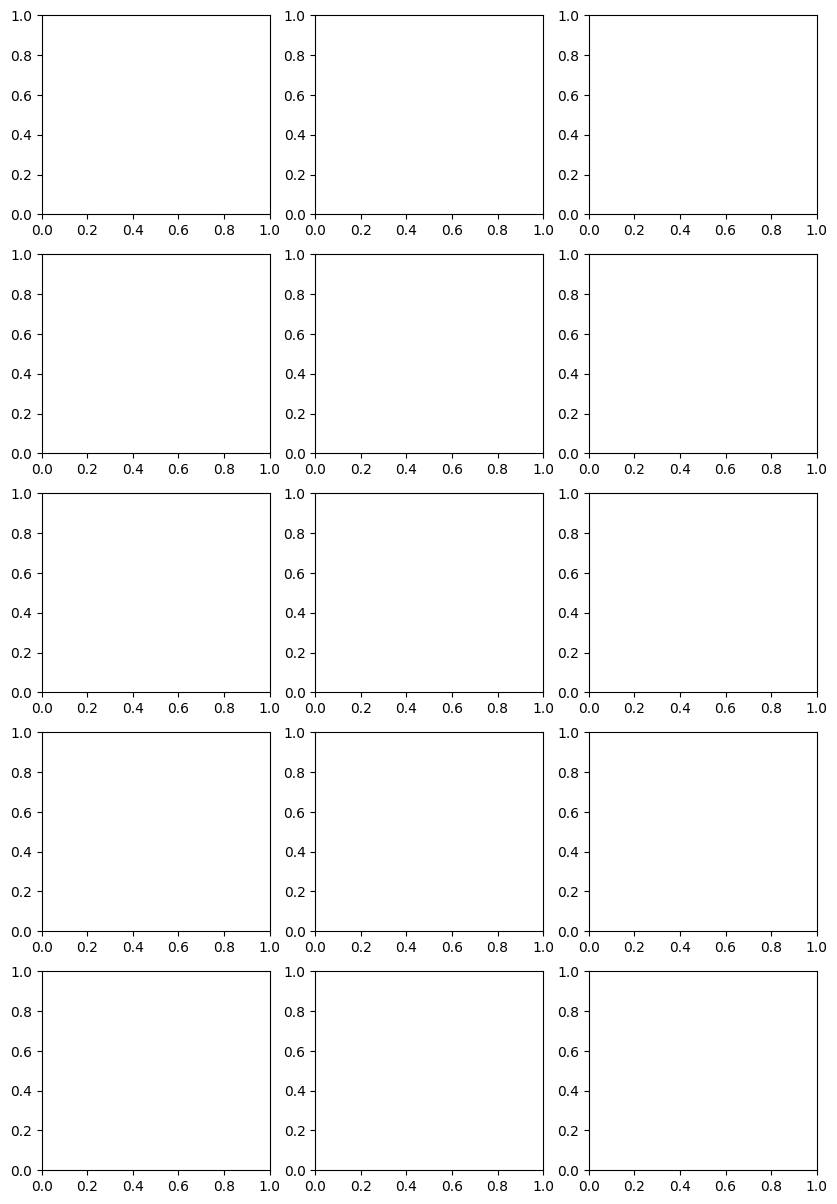

In [178]:
fig, axs = plt.subplots(5, 3, figsize=(10, 15))

axs = axs.flatten()
for i, ref_ano in enumerate(refs_anos):
    ref, ano = ref_ano
    for j in range(len(new_filtered_features[i])):
        axs[i + j].hist(
            ref[new_filtered_features[i][j]].astype(float).tolist(),
            label="Reference",
            alpha=0.5,
        )
        axs[i + j].hist(
            ano[new_filtered_features[i][j]].astype(float).tolist(),
            label="Anomaly",
            alpha=0.5,
        )

        axs[i + j].set_title(new_filtered_features[i][j], fontsize=6)

plt.show()

In [ ]:
fig, axs = plt.subplots(
    int(len(refs.columns[:-4]) / 2), 2, figsize=(10, 2 * len(refs.columns[:-4]))
)

axs = axs.flatten()
for i, item in enumerate(sorted(distances.items(), key=lambda x: x[1])):
    col = item[0]
    axs[i].hist(refs[col].astype(float).tolist(), label="Reference", alpha=0.5)
    axs[i].hist(anos[col].astype(float).tolist(), label="Anomaly", alpha=0.5)
    axs[i].ticklabel_format(style="plain")

    axs[i].set_title(col, fontsize=6)
    axs[i].legend()

plt.tight_layout()
plt.show()

### Getting absolute values and sorting them

In [ ]:
def absolute_and_sort_distances(distances: dict) -> dict:
    if all(value < 0 for value in distances.values()):
        positive_distances = {key: np.abs(value) for key, value in distances.items()}

    sorted_distances = dict(
        sorted(positive_distances.items(), key=lambda x: x[1], reverse=True)
    )

    return sorted_distances

In [ ]:
distances_bursty

In [ ]:
absolute_and_sort_distances(distances_bursty), absolute_and_sort_distances(
    distances_stalled
), absolute_and_sort_distances(distances_cpu)

In [ ]:
0.24461719290681788 - 0.11803854429547568

In [ ]:
def maximum_leap(distances: dict) -> float:
    ranked_distances = absolute_and_sort_distances(distances)

    leaps = [
        last_distance - distance
        for last_distance, distance in zip(
            ranked_distances.values(), list(ranked_distances.values())[1:]
        )
    ]

    maximum_leap = max(leaps)

    return maximum_leap

In [ ]:
maximum_leap(distances_bursty), maximum_leap(distances_stalled), maximum_leap(
    distances_cpu
)

In [ ]:
def reward_leap_filter(distances: dict) -> dict:
    ranked_distances = absolute_and_sort_distances(distances)
    threshold = maximum_leap(distances)
    to_be_discarded = set()

    last_distance = 0
    for feature, distance in ranked_distances.items():
        if last_distance != 0:
            leap = last_distance - distance
            if leap <= threshold:
                to_be_discarded.update([feature])
        last_distance = distance

    filtered_features = {
        feature: distance
        for feature, distance in distances.items()
        if feature not in to_be_discarded
    }

    return filtered_features

In [ ]:
reward_leap_filter(distances_bursty), reward_leap_filter(
    distances_stalled
), reward_leap_filter(distances_cpu)

#### Visual Checking
##### Bursty

In [ ]:
plt.bar(
    absolute_and_sort_distances(distances_bursty).keys(),
    absolute_and_sort_distances(distances_bursty).values(),
)
plt.axhline(
    y=np.median(list(absolute_and_sort_distances(distances_bursty).values())), c="r"
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming distances_bursty, absolute_and_sort_distances, and reward_leap_filter are defined

# Get distances and their absolute values
distances = absolute_and_sort_distances(distances_bursty)

# Get filtered distances
filtered_distances = reward_leap_filter(distances_bursty)

# Extract feature names and distances for plotting
feature_names = list(distances.keys())
all_distances = list(distances.values())

# Set color for bars
colors = [
    "orange" if feature in filtered_distances else "b" for feature in feature_names
]

# Plot the bar chart
plt.bar(feature_names, all_distances, color=colors)

# Add a red horizontal line at the median
plt.axhline(y=np.median(all_distances), color="r")

# Show the plot
plt.show()

##### Stalled

In [ ]:
plt.bar(
    absolute_and_sort_distances(distances_stalled).keys(),
    absolute_and_sort_distances(distances_stalled).values(),
)
plt.axhline(
    y=np.median(list(absolute_and_sort_distances(distances_stalled).values())), c="r"
)

In [ ]:
# Assuming distances_bursty, absolute_and_sort_distances, and reward_leap_filter are defined

# Get distances and their absolute values
distances = absolute_and_sort_distances(distances_stalled)

# Get filtered distances
filtered_distances = reward_leap_filter(distances_stalled)

# Extract feature names and distances for plotting
feature_names = list(distances.keys())
all_distances = list(distances.values())

# Set color for bars
colors = [
    "orange" if feature in filtered_distances else "b" for feature in feature_names
]

# Plot the bar chart
plt.bar(feature_names, all_distances, color=colors)

# Add a red horizontal line at the median
plt.axhline(y=np.median(all_distances), color="r")

# Show the plot
plt.show()

In [ ]:
##### CPU

In [ ]:
plt.bar(
    absolute_and_sort_distances(distances_cpu).keys(),
    absolute_and_sort_distances(distances_cpu).values(),
)
plt.axhline(
    y=np.median(list(absolute_and_sort_distances(distances_cpu).values())), c="r"
)

In [ ]:
# Assuming distances_bursty, absolute_and_sort_distances, and reward_leap_filter are defined

# Get distances and their absolute values
distances = absolute_and_sort_distances(distances_cpu)

# Get filtered distances
filtered_distances = reward_leap_filter(distances_cpu)

# Extract feature names and distances for plotting
feature_names = list(distances.keys())
all_distances = list(distances.values())

# Set color for bars
colors = [
    "orange" if feature in filtered_distances else "b" for feature in feature_names
]

# Plot the bar chart
plt.bar(feature_names, all_distances, color=colors)

# Add a red horizontal line at the median
plt.axhline(y=np.median(all_distances), color="r")

# Show the plot
plt.show()

### Elbow method

Là c'est une fonction que j'avais fait en attendant d'avoir ta fonction, je récupérais juste les 3 meilleures colonnes ! Je vais remodifier pour l'adapter à ton code

In [ ]:
for distance, new_ref_ano in zip(distances, new_refs_anos):
    top_cols = sorted(distance.items(), key=lambda x: x[1], reverse=True)[:3]
    top_cols = [col[0] for col in top_cols]
    ref, ano = new_ref_ano
    ref = ref[top_cols + ["type_data"]]
    ano = ano[top_cols + ["type_data"]]
    for feature in [col for col in ref.columns if col != "type_data"]:
        # On concatène les références et les anomalies pour la feature
        all_values = pd.concat(
            [ref.loc[:, [feature, "type_data"]], ano.loc[:, [feature, "type_data"]]]
        )

        # On trie les valeurs par feature puis par type_data
        sorted_values = all_values.sort_values(by=[feature, "type_data"])

        # On cherche les valeurs "boundary" (les valeurs qui séparent les anomalies des références)
        boundaries = []
        for i in range(sorted_values.shape[0] - 1):
            if sorted_values.iloc[i, 1] != sorted_values.iloc[i + 1, 1]:
                if sorted_values.iloc[i, 0] not in boundaries:
                    boundaries.append(sorted_values.iloc[i, 0])

        print(len(boundaries))
        print(boundaries)

In [ ]:
ref.loc[:, [feature, "type_data"]]

In [ ]:
ano

In [ ]:
all_values["type_data"].value_counts()

# Constructing final explanation

In [ ]:
bursty_anos.loc[:, new_filtered_features_bursty + ["type_data"]]

In [ ]:
for file in train_files:
    ano_ids = list(labels.loc[labels["trace_id"] == file, "ano_id"])
    for ano_id in ano_ids:
        selected_ref = refs.loc[
            (refs["ano_id"] == ano_id) & (refs["original_file"] == file), :
        ]
        selected_ano = anos.loc[
            (anos["ano_id"] == ano_id) & (anos["original_file"] == file), :
        ]

        break